In [2]:
#packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  accuracy_score,precision_score, recall_score,confusion_matrix
from scipy.stats import randint
import time
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [38]:
# Data import

train = pd.read_csv("/kaggle/input/titanic/train.csv")
test =  pd.read_csv("/kaggle/input/titanic/test.csv")

In [39]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
# General information
print("General information on the DataFrame")
train.info(verbose = True)

General information on the DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### step 1: descriptive analysis

In [41]:

train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

<AxesSubplot: >

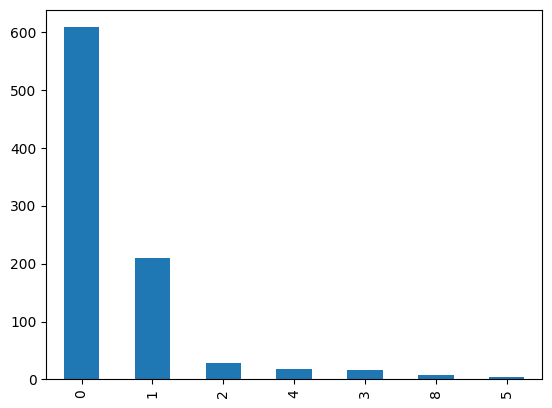

In [42]:
train['SibSp'].unique()
train['SibSp'].value_counts().plot(kind = 'bar')

<AxesSubplot: >

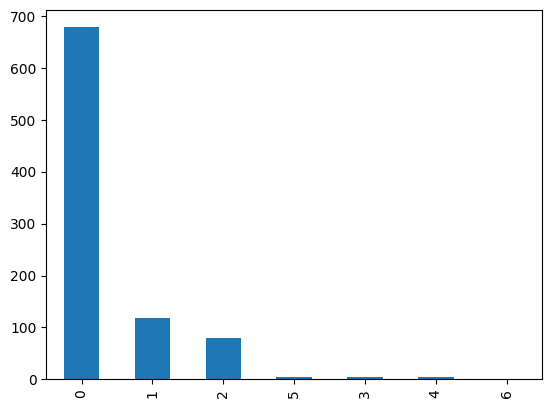

In [43]:
train['Parch'].value_counts().plot(kind = 'bar')

<AxesSubplot: >

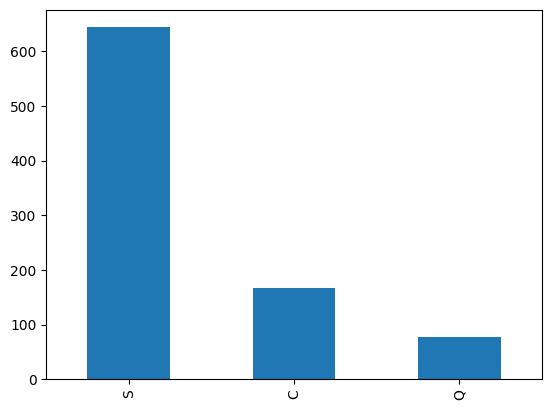

In [44]:
train['Embarked'].value_counts().plot(kind = 'bar')

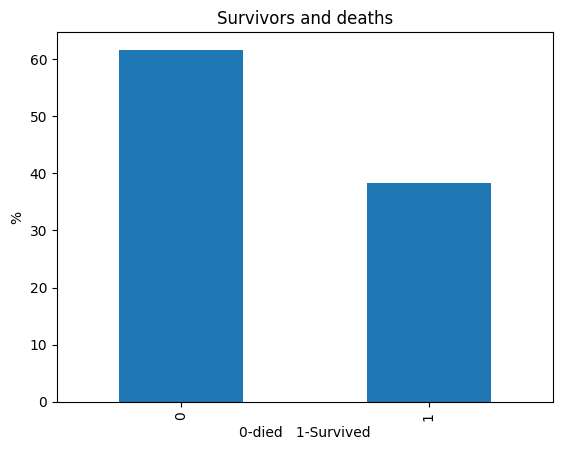

In [45]:
   #knowing balanced or imbalanced data on target variable
grouped = train.groupby('Survived').size()
grouped = grouped.apply(lambda x: x / len(train) * 100)
grouped.plot(kind='bar')
plt.ylabel("%")
plt.xlabel("0-died   1-Survived")
plt.title("Survivors and deaths")
plt.show()

### Cross statistics

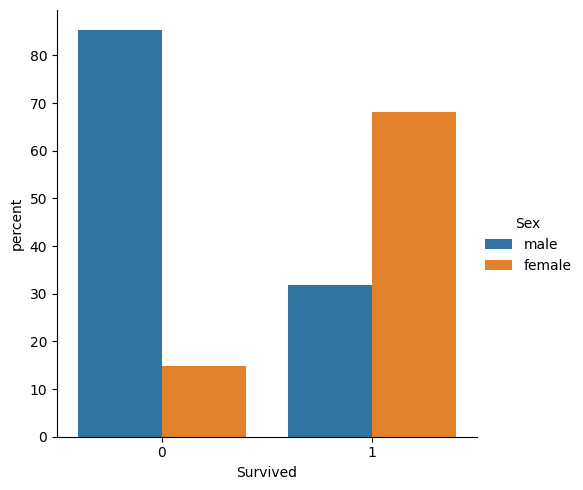

In [46]:
x="Survived"
y="Sex"
(train.groupby(x)[y].value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

More than 65% of survivors passengers where women, and 85% of deaths was men.

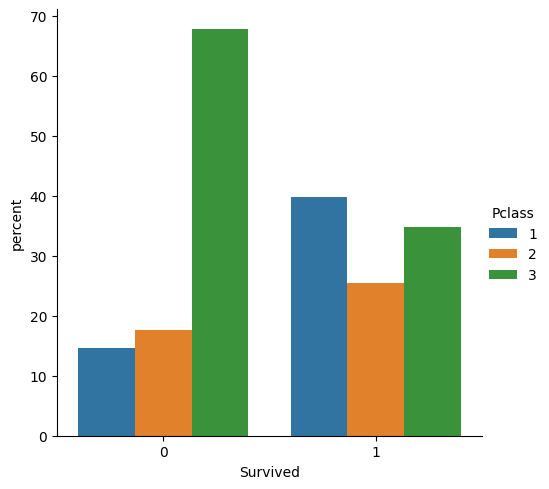

In [47]:
x="Survived"
y="Pclass"
(train.groupby(x)[y].value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

Around 70% of passengers who died were in class 3.

#### Missing values treat

In [48]:
train.isnull().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

There are more than 75% of missing values concerning the variable Cabin. For our study , we are not going to consider it as a feature.
The next variables having missing values is Age, less than 25% of missing values and Embarked with less than 1 of missiong values.
To deal with missing values in the Age variable, we have decided to impute the mean; and for the Embarked variable, we are simply going to delete observations with no value for this variable.

In [49]:
#delete observations with missing values on Embarked 
train.dropna(subset = ['Embarked'], axis = 0, inplace =True)
# iimpute the mean of Age
mean_age = train['Age'].mean()
train['Age'] = train['Age'].fillna(mean_age)

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.3+ KB


#### Label encoding

In [51]:
train.loc[:, 'genre'] = train['Sex'].map({'female': 0, 'male': 1})
test.loc[:, 'genre'] = test['Sex'].map({'female': 0, 'male': 1})

train.loc[:, 'Embarked_label'] = train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test.loc[:, 'Embarked_label'] = test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

#### Correlation Matrix between features

C:\Users\aurel\AppData\Local\Temp\ipykernel_12940\2715194678.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


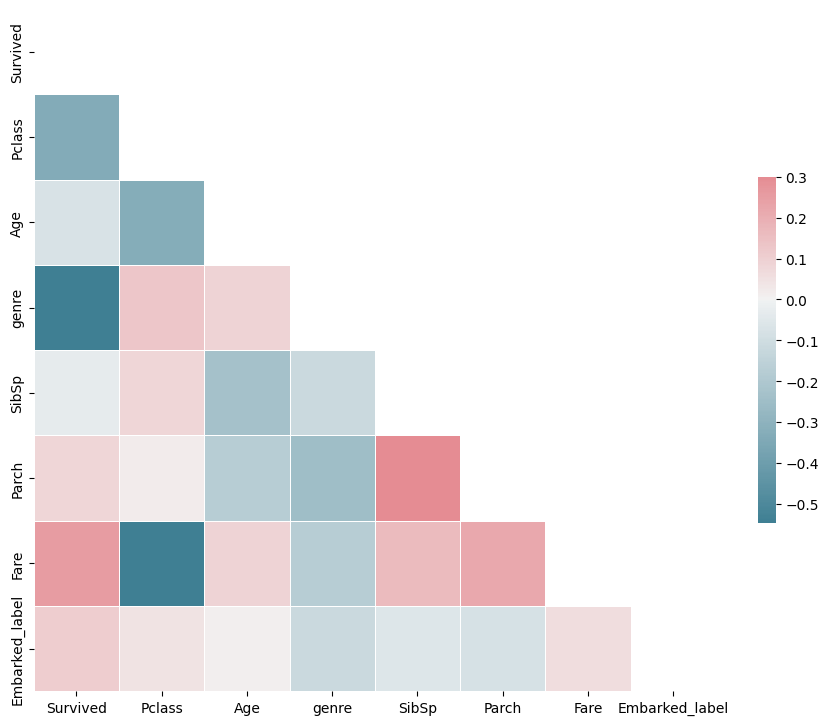

In [52]:
features = ['Survived','Pclass', 'Age', 'genre', 'SibSp','Parch', 'Fare', 'Embarked_label']
# Compute the correlation matrix
corr = train[features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))


f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [60]:
print(corr)

                Survived    Pclass       Age     genre     SibSp     Parch  \
Survived        1.000000 -0.335549 -0.074513 -0.541585 -0.034040  0.083151   
Pclass         -0.335549  1.000000 -0.328256  0.127741  0.081656  0.016824   
Age            -0.074513 -0.328256  1.000000  0.089339 -0.231908 -0.178013   
genre          -0.541585  0.127741  0.089339  1.000000 -0.116348 -0.247508   
SibSp          -0.034040  0.081656 -0.231908 -0.116348  1.000000  0.414542   
Parch           0.083151  0.016824 -0.178013 -0.247508  0.414542  1.000000   
Fare            0.255290 -0.548193  0.088780 -0.179958  0.160887  0.217532   
Embarked_label  0.108669  0.043835  0.008940 -0.118593 -0.060606 -0.079320   

                    Fare  Embarked_label  
Survived        0.255290        0.108669  
Pclass         -0.548193        0.043835  
Age             0.088780        0.008940  
genre          -0.179958       -0.118593  
SibSp           0.160887       -0.060606  
Parch           0.217532       -0.07932

After analysing the correlation matrix, we decided to ignore the SibSp, Parch, Embarked_label and Age variables in the rest of our study. This choice is explained by the low correlation between this variable and the target variable of the study.

## Classification

#### Construction of the training and test sets

In [70]:
#Training and test set
features = ['Pclass', 'genre',  'Fare']
X = train[features]
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)


# Select features to scale
features_to_scale = ['Fare']
scaler = MinMaxScaler()

# Fit and transform the selected features
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.fit_transform(X_test[features_to_scale])
test[features_to_scale] = scaler.fit_transform(test[features_to_scale])

### KNeighbors Classifier with selected features  without correlated variables

First, we will train the model with different hyperparameters to identify the ideal hyperparameter for our classification.
Next, we will train the model with the hyperparameter identified. In the rest of our project, we choose 7 as the hyper parameter on the basis of the accuracy and its confidence interval. 

In [71]:
start = time.perf_counter()

# values of the hyperparameters to be tested.
param_grid = {'n_neighbors':[3, 5, 7]}

score = 'accuracy'

# kNN classifier with hyperparameter search using cross-validation.
clf = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid,     
    cv=3,           
    scoring=score   
)

clf.fit(X_train, y_train)

print("Best hyperparameter(s) on the training set.:")
print(clf.best_params_)
print("Cross-validation results. :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # average score
        clf.cv_results_['std_test_score'],  # standard deviation of score
        clf.cv_results_['params']           # hyperparameter value
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

end = time.perf_counter()
print("Execution time:", end - start)

Best hyperparameter(s) on the training set.:
{'n_neighbors': 5}
Cross-validation results. :
accuracy = 0.779 (+/-0.040) for {'n_neighbors': 3}
accuracy = 0.789 (+/-0.038) for {'n_neighbors': 5}
accuracy = 0.786 (+/-0.050) for {'n_neighbors': 7}
Execution time: 0.0993187999993097


Now let's train our model and evaluate it.

In [72]:
clf = KNeighborsClassifier(n_neighbors = 7)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

Accuracy on test set: 0.8314606741573034
Precision on test set: 0.8304576905986162
Recall: on test set 0.8314606741573034
Accuracy on training set: 0.8227848101265823
Precision on training set: 0.8241077088294302
Recall: on training set 0.8227848101265823
    0   1
0  99  11
1  19  49
Execution time: 14.543447800009744


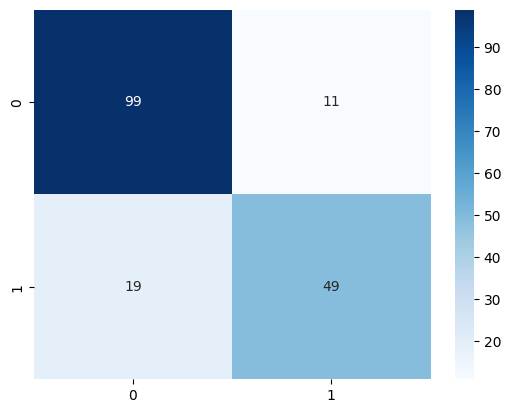

In [73]:
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

# evaluate the model using accuracy, precision, recall, and F1-score
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')


accuracy_training = accuracy_score(y_train, y_pred_train)
precision_training = precision_score(y_train, y_pred_train, average='weighted')
recall_training = recall_score(y_train, y_pred_train, average='weighted')


print("Accuracy on test set:", accuracy_test)
print("Precision on test set:", precision_test)
print("Recall: on test set", recall_test)


print("Accuracy on training set:", accuracy_training)
print("Precision on training set:", precision_training)
print("Recall: on training set", recall_training)


# calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# convert to a DataFrame
df_conf_matrix = pd.DataFrame(conf_matrix, index=clf.classes_, columns=clf.classes_)

df_conf_matrix = df_conf_matrix.astype(int)

# print the matrix
print(df_conf_matrix)
sns.heatmap(df_conf_matrix, annot = True, cmap = 'Blues')

end = time.perf_counter()
print("Execution time:", end - start)

Now we can make the prediction on the test set given as part of the project.

In [77]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,genre,Embarked_label
PassengerId,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,0.015282,NaN,Q,1,2
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,0.013663,NaN,S,0,0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,0.018909,NaN,Q,1,2
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,0.016908,NaN,S,1,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,0.023984,NaN,S,0,0


In [81]:
test[features].isnull().mean()*100

Pclass    0.000000
genre     0.000000
Fare      0.239234
dtype: float64

We note that there are missing values for the features used in the te test set. These missing values concern the Fare variable, which represents the ticket price. The strategy adopted to deal with these missing values is to impute the average ticket value for the class to which the passenger belongs. We calculate these class averages on the train set, which contains more information.

In [90]:
mean_per_class = train.groupby('Pclass')['Fare'].mean()
test['Fare'] = test.apply(lambda row: mean_per_class[row['Pclass']] if pd.isna(row['Fare']) else row['Fare'], axis=1)

In [92]:
y_pred = clf.predict(test[features])

In [100]:
final_result = pd.DataFrame(y_pred, columns=['Survived'])

# Specify the file path where you want to save the Excel file
excel_file_path = 'C:/Users/aurel/Documents/GIT/data_titanic/result.xlsx'

# Save the Pandas DataFrame to an Excel file
final_result.to_excel(excel_file_path, index=False)